<a href="https://colab.research.google.com/github/inf032/introducaoML/blob/master/Farm04.Metricas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
!pip install catboost
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Importação de Bibliotecas**


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics  import mean_squared_error
from sklearn.dummy import DummyRegressor

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.impute._base import _BaseImputer




**Classe para imputação e coluna de missing**

In [69]:
class ImputerWithMissingMark (BaseEstimator, TransformerMixin):

    def transformColunas_IMPUTED(self, X) -> pd.DataFrame :
      copia = X.copy()
      for col in self.col_name_with_nan :
          copia[f'{col}{self.postfix}'] = copia[col].isna().astype(int)
      return copia      

    def col_with_nan(self, X) -> list:
      list_col_with_nan = []
      copia = X.copy()
      for col in copia.columns :
        if(copia[col].isna().sum() > 0) :
          list_col_with_nan.append(col)
      return list_col_with_nan

    def col_num_with_nan(self, X) -> list:
      cols = X.shape[1]
      list_col_with_nan = []
      for col in range(cols):    
          if(np.count_nonzero(np.isnan(X[:,col])) > 0) :  
              list_col_with_nan.append(col)
      return list_col_with_nan        

    def __init__(self, imputer=KNNImputer(), postfix = '_IMPUTED'):
      self.imputer = imputer
      self.col_name = None
      self.fitted = False
      self.col_name_with_nan = None
      self.col_number_with_nan = None
      self.postfix = postfix

    def fit_DF(self, X):
      self.col_name = X.columns.values
      self.col_name_with_nan = self.col_with_nan(X)

    def fit_NP(self, X):
      self.col_number_with_nan = self.col_num_with_nan(X)

    def transform_DF(self, X):
      copia = self.transformColunas_IMPUTED(X)
      transformed = pd.DataFrame(self.imputer.transform(copia[self.col_name]))
      transformed.columns = X.columns
      transformed.index = X.index
      for col in self.col_name_with_nan :
        transformed[f'{col}{self.postfix}'] = copia[f'{col}{self.postfix}']
      return transformed

    def transform_NP(self, X):
      transformed = np.copy(X)
      vazio = np.zeros(shape=(X.shape[0],0))
      for col in self.col_number_with_nan:
        a_nan = [1 if np.isnan(x) else 0 for x in transformed[:,col]]
        vazio = np.append(vazio, np.c_[a_nan], axis = 1)
      transformed = self.imputer.transform(transformed)  
      for col in range(vazio.shape[1]) :
        transformed = np.append(transformed, np.c_[vazio[:, col]], axis = 1)
      return transformed      

    def fit(self, X, y=None):
      if(self.fitted == False) :
        self.fitted = True
        if(type(X) == pd.DataFrame) :
          self.fit_DF(X)
        else :
          self.fit_NP(X)  
        self.imputer.fit(X)
      return self

    def transform(self, X, y=None):
      if(self.fitted == True) :
        if(self.col_name is not None) :
          transformed = self.transform_DF(X)    
        else :
          transformed = self.transform_NP(X)    
        return transformed
      else :
        return X

    def get_params(self, deep=True):
      # retorna um dicionário com os atributos e seus respectivos valores
      return {"imputer": self.imputer, 
              "postfix": self.postfix}
      
    def set_params(self, **parameters):
      # iterando pelos elementos passados e definindo-os na classe
      for parameter, value in parameters.items():
        setattr(self, parameter, value)
      return self 

**Leitura dos Dados e Holdout**


In [70]:
SEED = 10


np.random.seed(SEED)
warnings.filterwarnings(action='once')

df = pd.read_csv('https://raw.githubusercontent.com/inf032/introducaoML/master/data/farmaco.csv')
df.columns = ['IDADE', 'SEXO', 'PA', 'COLESTEROL', 'NA_K', 'FARMACO']
preditoras = ['IDADE', 'SEXO', 'PA', 'COLESTEROL', 'NA_K']
alvo = 'FARMACO'

#df.sort_values(by=[alvo], ascending=True, inplace=True)
#df.index = range(df.shape[0])

#df




In [71]:
X = df[preditoras]
y = df[alvo]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=SEED)
#X_train = df.loc[0:157,preditoras]
#y_train = df.loc[0:157,alvo]
#X_test = df.loc[158:,preditoras]
#y_test = df.loc[158:,alvo]
print(f'Holdout: {X_train.shape[0]} individuos em treino. {X_test.shape[0]} individuos em teste.')

Holdout: 157 individuos em treino. 68 individuos em teste.


In [72]:
y_test

87     MEDA
26     MEDA
76     MEDB
68     MEDA
78     MEDB
       ... 
7      MEDB
224    MEDA
39     MEDB
171    MEDB
172    MEDA
Name: FARMACO, Length: 68, dtype: object

**Criação do Pipeline de Transformação dos Dados de Entrada**

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

ordinal_transformer = Pipeline(steps=[('ordinal_encoder', OrdinalEncoder(categories=[['LOW', 'NORMAL', 'HIGH'], 
                                                                                     ['LOW', 'NORMAL', 'HIGH']], 
                                                                          handle_unknown='use_encoded_value',
                                                                          unknown_value=np.nan))
                                     ])
onehot_transformer = Pipeline(steps=[('one_hot_encoder',  OneHotEncoder(drop='if_binary', sparse=False))])


col_transformer = ColumnTransformer(transformers=[('pa_colesterol', ordinal_transformer, ['PA', 'COLESTEROL']),
                                                  ('sex', onehot_transformer, ['SEXO'])],
                                    remainder='passthrough')

transformer = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()), 
                              ('imputer', ImputerWithMissingMark())])

**Criação de Tipos diferentes de classificadores, que serão usados na comparação**

In [74]:
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

nomes = ['Dummy', 'CatBoost', 'XGB', 'LightGBM', 'Random Forest', 'Rede Neural', 
         'Neural Net']

classificadores = [DummyClassifier(strategy='stratified'),
                   CatBoostClassifier(verbose=0), XGBClassifier(verbosity=0),
                   LGBMClassifier(),
                   RandomForestClassifier(),
                   MLPClassifier(max_iter=1000)]

**Função para Cálculo de Métricas**




In [75]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix

def calcular_metricas(model, X_test, y_true) :
  y_pred = model.predict(X_test)
  acuracia = accuracy_score(y_true, y_pred)
  precisao = precision_score(y_true, y_pred, average='micro')
  sensibilidade = recall_score(y_true, y_pred, average='micro')
  f1 = f1_score(y_true, y_pred, average='micro')
  return acuracia, precisao, sensibilidade, f1

def print_confusion_matrix(model, X_test, y_true) :
  y_pred = model.predict(X_test)
  cm = confusion_matrix(y_test, y_true)
  print(cm)


**Avaliação do Desempenho dos Classificadores**


In [76]:
resultados = []

for nome, classificador in zip(nomes, classificadores) :
    model = Pipeline(steps=[('transformer', transformer),
                            ('classificador', classificador)]).fit(X_train, y_train)

    acuracia, precisao, sensibilidade, f1 = calcular_metricas(model, X_test, y_test)                       
    resultados.append([nome, acuracia, precisao, sensibilidade, f1])
    
dfResultados = pd.DataFrame(resultados, columns = ['CLASSIFICADOR', 'ACURACIA', 'PRECISAO', 'SENSIBILIDADE', 'F1'])

dfResultados


,CLASSIFICADOR,ACURACIA,PRECISAO,SENSIBILIDADE,F1
0,Dummy,0.441176,0.441176,0.441176,0.441176
1,CatBoost,0.970588,0.970588,0.970588,0.970588
2,XGB,0.941176,0.941176,0.941176,0.941176
3,LightGBM,0.941176,0.941176,0.941176,0.941176
4,Random Forest,0.970588,0.970588,0.970588,0.970588
5,Rede Neural,0.897059,0.897059,0.897059,0.897059


In [77]:
lightgbm = Pipeline(steps=[('transformer', transformer),
                         ('classificador', LGBMClassifier())]).fit(X_train, y_train)
y_pred = lightgbm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[29  1]
 [ 3 35]]


**Função para Matriz de Confusão**

In [78]:
def graph_confusion_matrix(model, X_test, y_true) :
  y_pred = model.predict(X_test)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, xticklabels=['MEDA - Predição', 'MEDB - Predição'], 
              yticklabels=['MEDA - Real', 'MEDB - Real'])
  

def print_confusion_matrix(model, X_test, y_true) :
  y_pred = model.predict(X_test)
  cm = confusion_matrix(y_true, y_pred)
  print(cm)


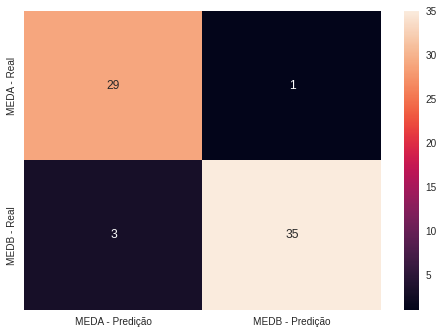

In [79]:
graph_confusion_matrix(lightgbm, X_test, y_test)

**Matriz de Confusão do Preditor**

In [80]:
#classificador = MLPClassifier(max_iter=650)

classificador = RandomForestClassifier(random_state=SEED)
model = Pipeline(steps=[('transformer', transformer), 
                        ('classificador', classificador)]).fit(X_train, y_train)

print_confusion_matrix(model, X_test, y_test)

[[29  1]
 [ 1 37]]


In [81]:
print_confusion_matrix(model, X_test, y_test)

[[29  1]
 [ 1 37]]


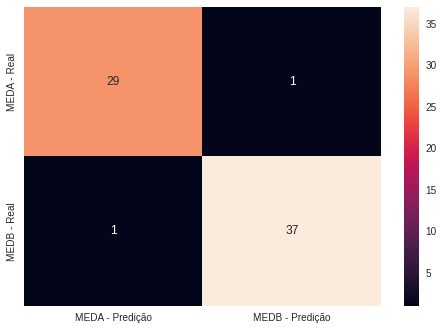

In [82]:
graph_confusion_matrix(model, X_test, y_test)

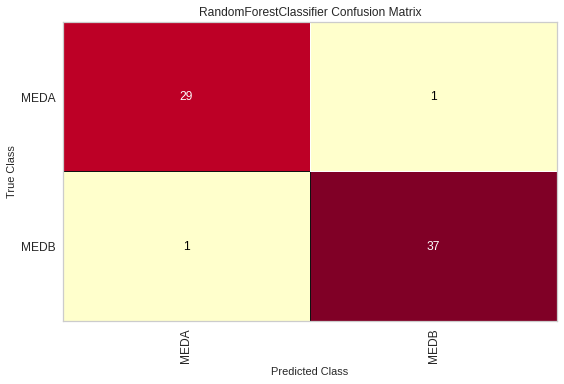

In [83]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(model, classes=['MEDA', 'MEDB'])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

**Relatório de Classificação**

In [84]:
from sklearn.metrics import classification_report

classificador = RandomForestClassifier()
transformer.fit(X_train, y_train)
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

        MEDA       0.97      0.97      0.97        30
        MEDB       0.97      0.97      0.97        38

    accuracy                           0.97        68
   macro avg       0.97      0.97      0.97        68
weighted avg       0.97      0.97      0.97        68



In [85]:
dfReport = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
dfReport

,MEDA,MEDB,accuracy,macro avg,weighted avg
precision,0.966667,0.973684,0.970588,0.970175,0.970588
recall,0.966667,0.973684,0.970588,0.970175,0.970588
f1-score,0.966667,0.973684,0.970588,0.970175,0.970588
support,30.000000,38.000000,0.970588,68.000000,68.000000


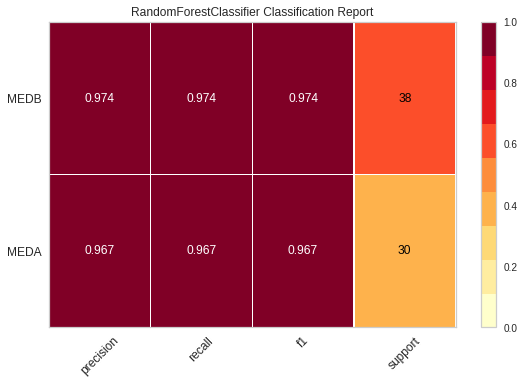

In [86]:
from yellowbrick.utils import is_fitted
from yellowbrick.classifier import ClassificationReport

le = LabelEncoder()
y_train_le = pd.Series(le.fit_transform(y_train))

cr = ClassificationReport(classificador, 
                          classes=['MEDA', 'MEDB'], support=True)

cr_model = Pipeline(steps=[('transformer', transformer), 
                           ('cr', cr)]).fit(X_train, y_train_le)

cr_model.score(X_test, le.transform(y_test))
cr_model['cr'].show()

**Cálculo de Valores da Curva ROC**

In [87]:
from sklearn.metrics import roc_curve

le = LabelEncoder()
le.fit(y_train)
y_pred = model.predict(X_test)
roc_curve(le.transform(y_test), le.transform(y_pred))



(array([0.        , 0.03333333, 1.        ]),
 array([0.        , 0.97368421, 1.        ]),
 array([2, 1, 0]))

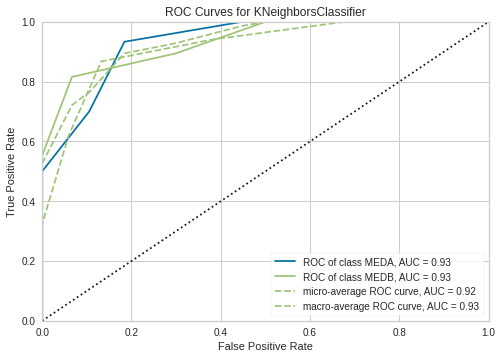

In [88]:
from sklearn.neighbors import KNeighborsClassifier
from yellowbrick.classifier import ROCAUC

le = LabelEncoder()
le.fit(y_train)

classificador = KNeighborsClassifier()
new_model = Pipeline(steps=[('transformer', transformer), 
                            ('classificador', classificador)]).fit(X_train,  le.transform(y_train))
                        
rocauc = ROCAUC(new_model, pos_label=0, classes=["MEDA", "MEDB"])

rocauc.fit(X_train, le.transform(y_train))
rocauc.score(X_test, le.transform(y_test))
rocauc.show()            

**Gráfico com a comparação dos Valores de Desempenho (Sensibilidade)**




In [90]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

METRICA = 'precision'
DESC_METRICA = 'PRECISAO'

def print_metrica(dfResultados, metrica) :
  fig = go.Figure()
  fig = px.scatter(dfResultados, x='CLASSIFICADOR', y=metrica)
  fig.update_layout(
      title=f"{metrica} por Modelo",
      xaxis_title="Classificador",
      yaxis_title= metrica,
      font=dict(
          family="Verdana",
          size=16,
          color="RebeccaPurple"
      )
  )
  fig.show()

print_metrica(dfResultados, DESC_METRICA)  

**Avaliação do Score dos Classificadores com Validação Cruzada (IC: 95%)**

In [91]:
from sklearn.model_selection import cross_validate


resultados_cv = []

for nome, model in zip(nomes, classificadores) :
    modelo = Pipeline(steps=[('transformer', transformer), ('classificador', model)])
    resultado_cv = cross_validate(modelo, X_train, le.transform(y_train), cv=5,scoring=METRICA)
    resultados_cv.append([nome, np.round(resultado_cv['test_score'].mean()*100,2), np.round(resultado_cv['test_score'].std()*100,2)])
    
dfResultados_cv = pd.DataFrame(resultados_cv, columns = ['CLASSIFICADOR', f'{DESC_METRICA}_MEDIO', f'{DESC_METRICA}_STD'])

dfResultados_cv.sort_values(by=[f'{DESC_METRICA}_MEDIO', f'{DESC_METRICA}_STD'], ascending=[False, False])

,CLASSIFICADOR,PRECISAO_MEDIO,PRECISAO_STD
5,Rede Neural,97.03,3.64
1,CatBoost,94.48,6.77
4,Random Forest,94.48,6.77
2,XGB,94.29,7.00
3,LightGBM,94.29,7.00
0,Dummy,42.34,6.59


**Otimização do Classificador para uma métrica diferente da padrão**

In [92]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import KFold

espaco_de_parametros = {
    'classificador__bootstrap' : [True, False],
    'classificador__max_depth' : randint(2,15),
    'classificador__min_samples_split': randint(2,15),
    'classificador__min_samples_leaf': randint(2,15),
    'classificador__n_estimators': randint(50,300),
    'classificador__criterion': ["gini", "entropy"]
}

cv = KFold(n_splits = 5, shuffle=True, random_state=327)


modelo = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()), 
                         ('imputer', ImputerWithMissingMark()), ('classificador', RandomForestClassifier())])

search = RandomizedSearchCV(modelo, espaco_de_parametros, 
                            n_iter = 25,
                            cv = cv,
                            scoring=METRICA,
                            random_state = SEED)

search.fit(X_train, le.transform(y_train))
resultados = pd.DataFrame(search.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classificador__bootstrap,param_classificador__criterion,param_classificador__max_depth,param_classificador__min_samples_leaf,param_classificador__min_samples_split,param_classificador__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.126316,0.003630,0.018260,0.000344,False,entropy,6,2,3,173,"{'classificador__bootstrap': False, 'classific...",1.0,0.9375,0.923077,0.857143,1.000,0.943544,0.053470,1
1,0.059321,0.003512,0.010374,0.000548,True,entropy,2,3,12,58,"{'classificador__bootstrap': True, 'classifica...",0.9,0.8750,0.857143,0.785714,0.875,0.858571,0.038901,25
2,0.144689,0.005572,0.022347,0.001308,False,gini,12,10,8,214,"{'classificador__bootstrap': False, 'classific...",0.9,0.9375,0.800000,0.800000,1.000,0.887500,0.078262,15
3,0.095814,0.003844,0.017309,0.002279,False,gini,6,13,8,138,"{'classificador__bootstrap': False, 'classific...",0.9,0.9375,0.800000,0.800000,1.000,0.887500,0.078262,15
4,0.166354,0.002044,0.025238,0.001176,False,gini,3,10,6,256,"{'classificador__bootstrap': False, 'classific...",0.9,0.9375,0.857143,0.800000,1.000,0.898929,0.068172,11


In [93]:
print(search.best_params_)
print(search.best_score_ * 100)

{'classificador__bootstrap': False, 'classificador__criterion': 'entropy', 'classificador__max_depth': 6, 'classificador__min_samples_leaf': 2, 'classificador__min_samples_split': 3, 'classificador__n_estimators': 173}
94.35439560439562
